In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import math
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time

In [16]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

In [17]:
data = pd.read_csv('C:\\Users\\Nordine\\OneDrive\\Documents\\Projet4-Openclassrooms-master\\Projet4-Openclassrooms-master\\data_cleaned.csv')

In [18]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ENERGYSTARScore', 'ComplianceStatus', 'ZipCode', 'Latitude',
       'Longitude', 'NumberofBuildings_log2', 'NumberofFloors_log2',
       'PropertyGFATotal_log2', 'PropertyGFAParking_log2',
       'PropertyGFABuilding(s)_log2', 'LargestPropertyUseTypeGFA_log2',
       'SecondLargestPropertyUseTypeGFA_log2', 'SiteEnergyUseWN(kBtu)_log2',
       'TotalGHGEmissions_log2'],
      dtype='object')

In [19]:
data['SiteEnergyUseWN(kBtu)_log2'].isna().sum()

0

## Préparation des données

In [21]:
#y = data['SiteEnergyUseWN(kBtu)_log2']
X = data.drop([ 'TotalGHGEmissions_log2', 'SiteEnergyUseWN(kBtu)_log2', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)


In [23]:
X.shape

(6581, 19)

In [7]:
X.shape

(6582, 19)

In [15]:
X.dtypes

DataYear                                float64
BuildingType                            object 
PrimaryPropertyType                     object 
CouncilDistrictCode                     float64
Neighborhood                            object 
YearBuilt                               float64
LargestPropertyUseType                  object 
SecondLargestPropertyUseType            object 
ComplianceStatus                        object 
ZipCode                                 float64
Latitude                                float64
Longitude                               float64
NumberofBuildings_log2                  float64
NumberofFloors_log2                     float64
PropertyGFATotal_log2                   float64
PropertyGFAParking_log2                 float64
PropertyGFABuilding(s)_log2             float64
LargestPropertyUseTypeGFA_log2          float64
SecondLargestPropertyUseTypeGFA_log2    float64
dtype: object

### Transformation des variables catégorielles

In [8]:
def preprocess(X):
    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.select_dtypes(['int32','float64', 'int64']).columns
    ohe = OneHotEncoder(sparse=False)
    ss = StandardScaler()
    X[numerical_columns] = ss.fit_transform(X[numerical_columns])
    ohe.fit_transform(X[categorical_columns])
    X = pd.merge(X[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X[categorical_columns])),
        left_index = True, right_index = True)
    return X



In [29]:
X.shape

(6580, 192)

In [30]:
y.shape

(6580,)

### Séparation des données en training et testing data

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

In [32]:
X_train.shape

(5264, 192)

In [33]:
y_train.shape

(5264,)

In [34]:
X_test.shape

(1316, 192)

In [35]:
y_test.shape

(1316,)

In [14]:
for col in X.select_dtypes(['int32','float64', 'int64']).columns:
    print(f'{col:-<50}{np.isfinite(X[col].values).all()}')

DataYear------------------------------------------True
CouncilDistrictCode-------------------------------True
YearBuilt-----------------------------------------True
ZipCode-------------------------------------------True
Latitude------------------------------------------True
Longitude-----------------------------------------True
NumberofBuildings_log2----------------------------True
NumberofFloors_log2-------------------------------True
PropertyGFATotal_log2-----------------------------True
PropertyGFAParking_log2---------------------------True
PropertyGFABuilding(s)_log2-----------------------True
LargestPropertyUseTypeGFA_log2--------------------True
SecondLargestPropertyUseTypeGFA_log2--------------True


## Modelisation

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [24]:
from sklearn.ensemble import RandomForestRegressor


def modelise(data, parameters, model, nom_model, X):
    results = pd.DataFrame({})
    gridDict = {}
    #X = data.drop([ 'TotalGHGEmissions_log2', 'SiteEnergyUseWN(kBtu)_log2', 'ENERGYSTARScore'], axis=1)
    for target in target_list: 
        print(target)
        print(data[target].head(5))
        X = preprocess(X)
        X_train, X_test, y_train, y_test = train_test_split(X, data[target], test_size = 0.2, random_state = 15)
        print(y_train.shape)
        print(y_test.shape)      
        grid = GridSearchCV(model,
                               param_grid = parameters,
                               verbose=2,
                               cv=4)
        grid.fit(X_train, y_train)
        gridDict[target] = grid
        print(math.sqrt(mean_squared_error(grid.predict(X_test), y_test)))
        print(grid.best_params_)
        results = results.append(pd.DataFrame({
            'Variable target' : [target],    
            'Modèle' : [nom_model],
            'Score RMSE' : [math.sqrt(mean_squared_error(grid.predict(X_test), y_test))],
            'Score RMSE / moyenne' : [math.sqrt(mean_squared_error(grid.predict(X_test), y_test))/ y_test.mean()],
            'Best param' :  [grid.best_params_]}),                     
              ignore_index=True)
    return results, gridDict



Commençons par une régression linéaire. Pour ceci, nous allons utiliser le modèle ElsaticNet qui permet de challenger via GridSearchCV la norme de régularisation (l1_ratio=1 pour une pénalité norme l1, l1_ratio=0 pour une pénalité norme l2, entre 0 et 1 pour une combinaison des 2).
Puis entrainons un modèle RandomForest ainsi qu'un SVR et un AdaBoost.
On récolte les résultats dans un Dataframe afin de comparer.

In [25]:

target_list = ['TotalGHGEmissions_log2', 'SiteEnergyUseWN(kBtu)_log2'] 
parameters = {'tol' : [0.1,0.01,0.001,0.0001], # seuil en dessous duquel sklearn ne cherche plus à optimiser
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #coefficient de pénalité
              "l1_ratio": np.arange(0.0, 1.0, 0.05)}

model = ElasticNet()
resEs, gridElasticNet = modelise(data, parameters, model, 'ElasticNet', X)
results = resEs

parameters = {
    'n_estimators' : [10,50,100], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] # auto = ttes les features / sqrt = sqrt(nbre de features)
}
model = RandomForestRegressor()
resFt, gridForest = modelise(data, parameters, model, 'Random Forest',X)
results = results.append(resFt)

parameters = {'gamma' : [1e-3, 1e-2, 1e-1], #coefficient permettant de coller plus ou moins aux données
              'epsilon' : [0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.1, 1, 10]} #parametre de régularisation

model = SVR()
resSv, grid = modelise(data, parameters, model, 'SVR',X)
results = results.append(resSv)

parameters = {
    'n_estimators' : [100,500,1000]
}
model = AdaBoostRegressor()
resAb, gridAdaBoost = modelise(data, parameters, model, 'ADABoost Regressor',X)
results = results.append(resAb)
results 

TotalGHGEmissions_log2
0    8.019202 
1    8.095450 
2    11.016446
3    9.015973 
4    8.297467 
Name: TotalGHGEmissions_log2, dtype: float64
(5264,)
(1317,)
Fitting 4 folds for each of 560 candidates, totalling 2240 fits
[CV] END ................alpha=0.0001, l1_ratio=0.0, tol=0.1; total time=   1.5s
[CV] END ................alpha=0.0001, l1_ratio=0.0, tol=0.1; total time=   1.3s
[CV] END ................alpha=0.0001, l1_ratio=0.0, tol=0.1; total time=   1.6s
[CV] END ................alpha=0.0001, l1_ratio=0.0, tol=0.1; total time=   1.4s
[CV] END ...............alpha=0.0001, l1_ratio=0.0, tol=0.01; total time=   1.3s
[CV] END ...............alpha=0.0001, l1_ratio=0.0, tol=0.01; total time=   1.2s
[CV] END ...............alpha=0.0001, l1_ratio=0.0, tol=0.01; total time=   1.3s
[CV] END ...............alpha=0.0001, l1_ratio=0.0, tol=0.01; total time=   1.3s
[CV] END ..............alpha=0.0001, l1_ratio=0.0, tol=0.001; total time=   1.2s
[CV] END ..............alpha=0.0001, l1_ratio=0.

[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1; total time=   0.3s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.6s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.7s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.5s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.9s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.9s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.001; total time=   1.0s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.7s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.001; total time=   1.5s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001; total time=   1.1s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001; total time=   1.7s
[CV] EN

[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.5s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.6s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.5s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.7s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.6s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001; total time=   1.0s
[CV] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001; total time=   1.3s
[CV] END ...............alpha=0.0001, l1_ratio=0.65, tol=0.1; total time=   0.2s
[CV] END ...............alpha=0.0001, l1_ratio=0.65, tol=0.1; total time=   0.2s
[CV] END ...............alpha=0.0001, l1_ratio=0.65, tol=0.1; total time=   0.2s
[CV] END ...............alpha=0.0001, l1_ratio=0.65, tol=0.1; total time=   0.2s
[CV] END .......

[CV] END .............alpha=0.0001, l1_ratio=0.9, tol=0.0001; total time=   0.8s
[CV] END .............alpha=0.0001, l1_ratio=0.9, tol=0.0001; total time=   0.8s
[CV] END .............alpha=0.0001, l1_ratio=0.9, tol=0.0001; total time=   0.8s
[CV] END .alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.1s
[CV] END .alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.1s
[CV] END .alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.1s
[CV] END .alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.1s
[CV] END alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.4s
[CV] END alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.2s
[CV] END alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.6s
[CV] END alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.4s
[CV] END alpha=0.0001, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.6s
[CV] END alpha=0.0001, l1_r

[CV] END ................alpha=0.001, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ................alpha=0.001, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.25, tol=0.01; total time=   0.1s
[CV] END ..............alpha=0.001, l1_ratio=0.25, tol=0.001; total time=   0.1s
[CV] END ..............alpha=0.001, l1_ratio=0.25, tol=0.001; total time=   0.1s
[CV] END ..............alpha=0.001, l1_ratio=0.25, tol=0.001; total time=   0.1s
[CV] END ..............alpha=0.001, l1_ratio=0.25, tol=0.001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.25, tol=0.0001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.25, tol=0.0001; total time=   0.1s
[CV] END .............alpha=

[CV] END ...............alpha=0.001, l1_ratio=0.55, tol=0.01; total time=   0.1s
[CV] END ..............alpha=0.001, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.55, tol=0.001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.55, tol=0.0001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.55, tol=0.0001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.55, tol=0.0001; total time=   0.1s
[CV] END .............alpha=0.001, l1_ratio=0.55, tol=0.0001; total time=   0.1s
[CV] END ..alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ..alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ..alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ..alpha=0.001, l1_r

[CV] END alpha=0.001, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.1s
[CV] END .................alpha=0.001, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.001, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.001, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.001, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ................alpha=0.001, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.001, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.001, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.001, l1_ratio=0.9, tol=0.01; total time=   0.1s
[CV] END ...............alpha=0.001, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ...............a

[CV] END .................alpha=0.01, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END .................al

[CV] END ................alpha=0.01, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ................alp

[CV] END ..alpha=0.01, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=0.01, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ..................a

[CV] END alpha=0.1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END alpha=0.1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END ...................alpha=0.1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ...................alpha=0.1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ...................alpha=0.1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ...................alpha=0.1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................al

[CV] END ..................alpha=0.1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ..................a

[CV] END ................alpha=0.1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.1, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=0.1, l1_rat

[CV] END ...alpha=1, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ...alpha=1, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ...alpha=1, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ..alpha=1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END ..alpha=1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END ..alpha=1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END ..alpha=1, l1_ratio=0.15000000000000002, tol=0.0001; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ...................

[CV] END .....................alpha=1, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.5, tol=0.001; total time=   0.0s
[CV] END ..................a

[CV] END ...................alpha=1, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.8, tol=0.0001; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.8500000000000001, tol=0.1; total time=   0.0s
[CV] END .....alpha=1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END .....alpha=1, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END .....alpha=1, l1_ra

[CV] END ....alpha=10, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ....alpha=10, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ....alpha=10, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ....alpha=10, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ...alpha=10, l1_ratio=0.15000000000000002, tol=0.01; total time=   0.0s
[CV] END ...alpha=10, l1_ratio=0.15000000000000002, tol=0.01; total time=   0.0s
[CV] END ...alpha=10, l1_ratio=0.15000000000000002, tol=0.01; total time=   0.0s
[CV] END ...alpha=10, l1_ratio=0.15000000000000002, tol=0.01; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.15000000000000002, tol=0.001; total time=   0.0s
[CV] END .alpha=10, l1_ratio

[CV] END .................alpha=10, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.45, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.45, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.45, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.45, tol=0.0001; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.5, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.5, tol=0.01; total time=   0.0s
[CV] END ...................

[CV] END ....................alpha=10, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.8, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.8, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.8, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.8, tol=0.01; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.8, tol=0.001; total time=   0.0s
[CV] END .................al

[CV] END ..................alpha=100, l1_ratio=0.1, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.1, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.1, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.1, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.1, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.1, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.1, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.1, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.1, tol=0.0001; total time=   0.0s
[CV] END ...alpha=100, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ...alpha=100, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ...alpha=100, l1_ratio=0.15000000000000002, tol=0.1; total time=   0.0s
[CV] END ...alpha=100, l1_ra

[CV] END ..................alpha=100, l1_ratio=0.45, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.45, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.45, tol=0.1; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.45, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.45, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.45, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.45, tol=0.01; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.45, tol=0.001; total time=   0.0s
[CV] END ...............alpha=100, l1_ratio=0.45, tol=0.0001; total time=   0.0s
[CV] END ...............alph

[CV] END .................alpha=100, l1_ratio=0.75, tol=0.01; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.75, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.75, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.75, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.75, tol=0.001; total time=   0.0s
[CV] END ...............alpha=100, l1_ratio=0.75, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=100, l1_ratio=0.75, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=100, l1_ratio=0.75, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=100, l1_ratio=0.75, tol=0.0001; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.8, tol=0.1; total time=   0.0s
[CV] END ...................

[CV] END .............alpha=0.0001, l1_ratio=0.05, tol=0.001; total time=   1.3s
[CV] END .............alpha=0.0001, l1_ratio=0.05, tol=0.001; total time=   1.3s
[CV] END .............alpha=0.0001, l1_ratio=0.05, tol=0.001; total time=   1.3s
[CV] END ............alpha=0.0001, l1_ratio=0.05, tol=0.0001; total time=   1.4s
[CV] END ............alpha=0.0001, l1_ratio=0.05, tol=0.0001; total time=   1.4s
[CV] END ............alpha=0.0001, l1_ratio=0.05, tol=0.0001; total time=   1.3s
[CV] END ............alpha=0.0001, l1_ratio=0.05, tol=0.0001; total time=   1.3s
[CV] END ................alpha=0.0001, l1_ratio=0.1, tol=0.1; total time=   0.3s
[CV] END ................alpha=0.0001, l1_ratio=0.1, tol=0.1; total time=   1.3s
[CV] END ................alpha=0.0001, l1_ratio=0.1, tol=0.1; total time=   1.3s
[CV] END ................alpha=0.0001, l1_ratio=0.1, tol=0.1; total time=   1.7s
[CV] END ...............alpha=0.0001, l1_ratio=0.1, tol=0.01; total time=   1.3s
[CV] END ...............alph

[CV] END alpha=0.0001, l1_ratio=0.35000000000000003, tol=0.0001; total time=   1.2s
[CV] END alpha=0.0001, l1_ratio=0.35000000000000003, tol=0.0001; total time=   1.0s
[CV] END ................alpha=0.0001, l1_ratio=0.4, tol=0.1; total time=   0.2s
[CV] END ................alpha=0.0001, l1_ratio=0.4, tol=0.1; total time=   0.1s
[CV] END ................alpha=0.0001, l1_ratio=0.4, tol=0.1; total time=   0.2s
[CV] END ................alpha=0.0001, l1_ratio=0.4, tol=0.1; total time=   0.2s
[CV] END ...............alpha=0.0001, l1_ratio=0.4, tol=0.01; total time=   1.4s
[CV] END ...............alpha=0.0001, l1_ratio=0.4, tol=0.01; total time=   1.7s
[CV] END ...............alpha=0.0001, l1_ratio=0.4, tol=0.01; total time=   1.5s
[CV] END ...............alpha=0.0001, l1_ratio=0.4, tol=0.01; total time=   1.8s
[CV] END ..............alpha=0.0001, l1_ratio=0.4, tol=0.001; total time=   1.4s
[CV] END ..............alpha=0.0001, l1_ratio=0.4, tol=0.001; total time=   1.3s
[CV] END .............

[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01; total time=   1.4s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01; total time=   1.4s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.001; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.001; total time=   1.4s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.001; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.001; total time=   1.3s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001; total time=   0.9s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001; total time=   0.9s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001; total time=   0.9s
[CV] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001; total time=   0.9s
[CV] END .......

[CV] END ...............alpha=0.001, l1_ratio=0.0, tol=0.001; total time=   1.3s
[CV] END ...............alpha=0.001, l1_ratio=0.0, tol=0.001; total time=   1.3s
[CV] END ...............alpha=0.001, l1_ratio=0.0, tol=0.001; total time=   1.3s
[CV] END ..............alpha=0.001, l1_ratio=0.0, tol=0.0001; total time=   1.1s
[CV] END ..............alpha=0.001, l1_ratio=0.0, tol=0.0001; total time=   0.9s
[CV] END ..............alpha=0.001, l1_ratio=0.0, tol=0.0001; total time=   1.2s
[CV] END ..............alpha=0.001, l1_ratio=0.0, tol=0.0001; total time=   1.1s
[CV] END ................alpha=0.001, l1_ratio=0.05, tol=0.1; total time=   0.2s
[CV] END ................alpha=0.001, l1_ratio=0.05, tol=0.1; total time=   0.5s
[CV] END ................alpha=0.001, l1_ratio=0.05, tol=0.1; total time=   0.5s
[CV] END ................alpha=0.001, l1_ratio=0.05, tol=0.1; total time=   0.5s
[CV] END ...............alpha=0.001, l1_ratio=0.05, tol=0.01; total time=   0.7s
[CV] END ...............alph

[CV] END alpha=0.001, l1_ratio=0.30000000000000004, tol=0.0001; total time=   0.7s
[CV] END alpha=0.001, l1_ratio=0.30000000000000004, tol=0.0001; total time=   0.8s
[CV] END .alpha=0.001, l1_ratio=0.35000000000000003, tol=0.1; total time=   0.0s
[CV] END .alpha=0.001, l1_ratio=0.35000000000000003, tol=0.1; total time=   0.0s
[CV] END .alpha=0.001, l1_ratio=0.35000000000000003, tol=0.1; total time=   0.0s
[CV] END .alpha=0.001, l1_ratio=0.35000000000000003, tol=0.1; total time=   0.0s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.01; total time=   0.3s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.01; total time=   0.3s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.01; total time=   0.2s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.01; total time=   0.4s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.001; total time=   0.7s
[CV] END alpha=0.001, l1_ratio=0.35000000000000003, tol=0.001; total time=   0.5s
[CV] END alpha=0.001, 

[CV] END ...............alpha=0.001, l1_ratio=0.65, tol=0.01; total time=   0.5s
[CV] END ...............alpha=0.001, l1_ratio=0.65, tol=0.01; total time=   0.2s
[CV] END ...............alpha=0.001, l1_ratio=0.65, tol=0.01; total time=   0.1s
[CV] END ...............alpha=0.001, l1_ratio=0.65, tol=0.01; total time=   0.5s
[CV] END ..............alpha=0.001, l1_ratio=0.65, tol=0.001; total time=   0.4s
[CV] END ..............alpha=0.001, l1_ratio=0.65, tol=0.001; total time=   0.3s
[CV] END ..............alpha=0.001, l1_ratio=0.65, tol=0.001; total time=   0.3s
[CV] END ..............alpha=0.001, l1_ratio=0.65, tol=0.001; total time=   0.4s
[CV] END .............alpha=0.001, l1_ratio=0.65, tol=0.0001; total time=   0.3s
[CV] END .............alpha=0.001, l1_ratio=0.65, tol=0.0001; total time=   1.1s
[CV] END .............alpha=0.001, l1_ratio=0.65, tol=0.0001; total time=   0.9s
[CV] END .............alpha=0.001, l1_ratio=0.65, tol=0.0001; total time=   0.5s
[CV] END ..alpha=0.001, l1_r

[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.3s
[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.1s
[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.0001; total time=   0.5s
[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.0001; total time=   0.6s
[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.0001; total time=   0.5s
[CV] END alpha=0.001, l1_ratio=0.9500000000000001, tol=0.0001; total time=   0.3s
[CV] END ..................alpha=0.01, l1_ratio=0.0, tol=0.1; total time=   1.7s
[CV] END ..................alpha=0.01, l1_ratio=0.0, tol=0.1; total time=   1.7s
[CV] END ..................alpha=0.01, l1_ratio=0.0, tol=0.1; total time=   1.3s
[CV] END ..................alpha=0.01, l1_ratio=0.0, tol=0.1; total time=   1.3s
[CV] END .................alpha=0.01, l1_ratio=0.0, tol=0.01; total time=   1.3s
[CV] END .................alpha=0.01, l1_ratio=0.0, tol=0.01; total time=   1.3s
[CV] END ...............

[CV] END ..alpha=0.01, l1_ratio=0.30000000000000004, tol=0.1; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.30000000000000004, tol=0.1; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.30000000000000004, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.0001; total time=   0.1s
[CV] END alpha=0.01, l1_ratio=0.30000000000000004, tol=0.0001; total time=   0.1s
[CV] END alpha=0.01, l1_ra

[CV] END .alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.1s
[CV] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.1s
[CV] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.2s
[CV] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001; total time=   0.1s
[CV] END .................alpha=0.01, l1_ratio=0.65, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.65, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.65, tol=0.1; total time=   0.0s
[CV] END .................alpha=0.01, l1_ratio=0.65, tol=0.1; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.65, tol=0.01; total time=   0.0s
[CV] END ................alp

[CV] END ...............alpha=0.01, l1_ratio=0.9, tol=0.0001; total time=   0.6s
[CV] END ...alpha=0.01, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.01, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.01, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.01, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.01, l1_ratio=0.9500000000000001, tol=0.01; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_ratio=0.9500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=0.01, l1_rat

[CV] END .................alpha=0.1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.1, l1_ratio=0.25, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.1, l1_ratio=0.25, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.1, l1_ratio=0.25, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.1, l1_ratio=0.25, tol=0.0001; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.30000000000000004, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.30000000000000004, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.1, l1_ra

[CV] END ...............alpha=0.1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ...............alpha=0.1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01; total time=   0.0s
[CV] END ...alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=0.1, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=0.1, l1_ratio=0.6000000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=0.1, l1_rat

[CV] END ..................alpha=0.1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ..................alpha=0.1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END .................alpha=0.1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ................alpha=0.1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_ratio=0.9500000000000001, tol=0.1; total time=   0.0s
[CV] END ....alpha=0.1, l1_r

[CV] END ..................alpha=1, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.25, tol=0.01; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.25, tol=0.001; total time=   0.0s
[CV] END ..................a

[CV] END ...................alpha=1, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END .................alpha=1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END .................alpha=1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END .................alpha=1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END .................alpha=1, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ......alpha=1, l1_ratio=0.6000000000000001, tol=0.1; total time=   0.0s
[CV] END ......alpha=1, l1_r

[CV] END .....................alpha=1, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END .....................alpha=1, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ....................alpha=1, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ...................alpha=1, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=1, l1_ratio=0.9, tol=0.0001; total time=   0.0s
[CV] END ..................a

[CV] END ..................alpha=10, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.25, tol=0.1; total time=   0.0s
[CV] END ..................a

[CV] END ..................alpha=10, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END .................alpha=10, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END ................alpha=10, l1_ratio=0.55, tol=0.0001; total time=   0.0s
[CV] END .....alpha=10, l1_r

[CV] END ..alpha=10, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END ..alpha=10, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ....................alpha=10, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ...................alpha=10, l1_ratio=0.9, tol=0.01; total time=   0.0s
[CV] END ..................alpha=10, l1_ratio=0.9, tol=0.001; total time=   0.0s
[CV] END ..................a

[CV] END ...................alpha=100, l1_ratio=0.2, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.2, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.2, tol=0.0001; total time=   0.0s
[CV] END ................alp

[CV] END ................alpha=100, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.5, tol=0.0001; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END ..................alpha=100, l1_ratio=0.55, tol=0.1; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END .................alpha=100, l1_ratio=0.55, tol=0.01; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ................alpha=100, l1_ratio=0.55, tol=0.001; total time=   0.0s
[CV] END ................alp

[CV] END ...alpha=100, l1_ratio=0.8500000000000001, tol=0.01; total time=   0.0s
[CV] END ..alpha=100, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=100, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=100, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END ..alpha=100, l1_ratio=0.8500000000000001, tol=0.001; total time=   0.0s
[CV] END .alpha=100, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END .alpha=100, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END .alpha=100, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END .alpha=100, l1_ratio=0.8500000000000001, tol=0.0001; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ...................alpha=100, l1_ratio=0.9, tol=0.1; total time=   0.0s
[CV] END ...................

[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total t

[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.4s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total t

[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   3.9s
[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   3.9s
[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   3.9s
[CV] END ........................C=1, epsilon=0.1, gamma=0.1; total time=   4.2s
[CV] END ........................C=1, epsilon=0.1, gamma=0.1; total time=   5.1s
[CV] END ........................C=1, epsilon=0.1, gamma=0.1; total time=   5.3s
[CV] END ........................C=1, epsilon=0.1, gamma=0.1; total time=   4.9s
[CV] END ........................C=1, epsilon=1, gamma=0.001; total time=   1.9s
[CV] END ........................C=1, epsilon=1, gamma=0.001; total time=   1.7s
[CV] END ........................C=1, epsilon=1, gamma=0.001; total time=   1.6s
[CV] END ........................C=1, epsilon=1, gamma=0.001; total time=   1.6s
[CV] END .........................C=1, epsilon=1, gamma=0.01; total time=   1.3s
[CV] END ...................

[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   4.8s
[CV] END .......................C=1, epsilon=0.01, gamma=0.1; total time=   4.6s
[CV] END .......................C=1, epsilon=0.01, gamma=0.1; total time=   4.7s
[CV] END .......................C=1, epsilon=0.01, gamma=0.1; total time=   6.3s
[CV] END .......................C=1, epsilon=0.01, gamma=0.1; total time=   5.8s
[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   4.1s
[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   4.0s
[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   4.0s
[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   3.8s
[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   3.8s
[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   3.9s
[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   4.1s
[CV] END ...................

,Variable target,Modèle,Score RMSE,Score RMSE / moyenne,Best param
0,TotalGHGEmissions_log2,ElasticNet,0.954446,0.168333,"{'alpha': 0.001, 'l1_ratio': 0.05, 'tol': 0.01}"
1,SiteEnergyUseWN(kBtu)_log2,ElasticNet,1.314065,0.062552,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.0001}"
0,TotalGHGEmissions_log2,Random Forest,0.662752,0.116887,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}"
1,SiteEnergyUseWN(kBtu)_log2,Random Forest,1.377628,0.065578,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}"
0,TotalGHGEmissions_log2,SVR,0.922624,0.162720,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"
1,SiteEnergyUseWN(kBtu)_log2,SVR,1.318744,0.062775,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.001}"
0,TotalGHGEmissions_log2,ADABoost Regressor,1.183675,0.208761,{'n_estimators': 100}
1,SiteEnergyUseWN(kBtu)_log2,ADABoost Regressor,2.482295,0.118162,{'n_estimators': 100}


Les deux colonnes obtiennent déjà un bon score RMSE / moyenne. Tout spécialement la deuxième colonne.

In [26]:
results = resEs
results = results.append(resFt)
results = results.append(resSv)
results = results.append(resAb)
results = results.reset_index()
results

,index,Variable target,Modèle,Score RMSE,Score RMSE / moyenne,Best param
0,0,TotalGHGEmissions_log2,ElasticNet,0.954446,0.168333,"{'alpha': 0.001, 'l1_ratio': 0.05, 'tol': 0.01}"
1,1,SiteEnergyUseWN(kBtu)_log2,ElasticNet,1.314065,0.062552,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.0001}"
2,0,TotalGHGEmissions_log2,Random Forest,0.662752,0.116887,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}"
3,1,SiteEnergyUseWN(kBtu)_log2,Random Forest,1.377628,0.065578,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}"
4,0,TotalGHGEmissions_log2,SVR,0.922624,0.162720,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"
5,1,SiteEnergyUseWN(kBtu)_log2,SVR,1.318744,0.062775,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.001}"
6,0,TotalGHGEmissions_log2,ADABoost Regressor,1.183675,0.208761,{'n_estimators': 100}
7,1,SiteEnergyUseWN(kBtu)_log2,ADABoost Regressor,2.482295,0.118162,{'n_estimators': 100}


## Random Forest Regressor

Regardons l'importance des 20 premières features pour les deux colonnes:

In [28]:
def plotBestFeature(gridDict, model):
    coefficients_totGH = abs(gridDict['TotalGHGEmissions_log2'].best_estimator_.feature_importances_)
    coefficients_siteEn = abs(gridDict['SiteEnergyUseWN(kBtu)_log2'].best_estimator_.feature_importances_)
    liste_coefs_totGH = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients_totGH, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
    liste_coefs_siteEN = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                       pd.DataFrame(coefficients_siteEn, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
    title1 = model + ' - Importance des 20 premières Features vs TotalGHGEmissions_log2'
    title2 = model + ' - Importance des 20 premières Features vs SiteEnergyUseWN(kBtu)_log2'
    plt.figure(figsize=(8,8))
    plt.title(title1)
    sns.barplot(y = liste_coefs_totGH['Variable'].head(20),
            x = liste_coefs_totGH['Coefficient'].head(20))
    plt.show()

    plt.figure(figsize=(8,8))
    plt.title(title2)
    sns.barplot(y = liste_coefs_siteEN['Variable'].head(20),
            x = liste_coefs_siteEN['Coefficient'].head(20))
    plt.show()
    


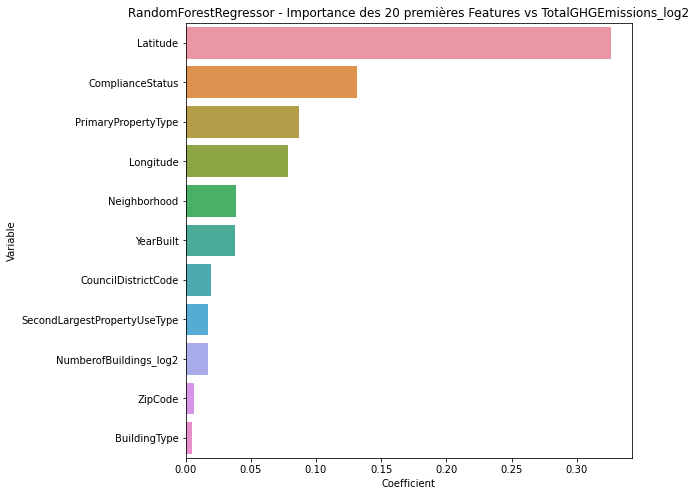

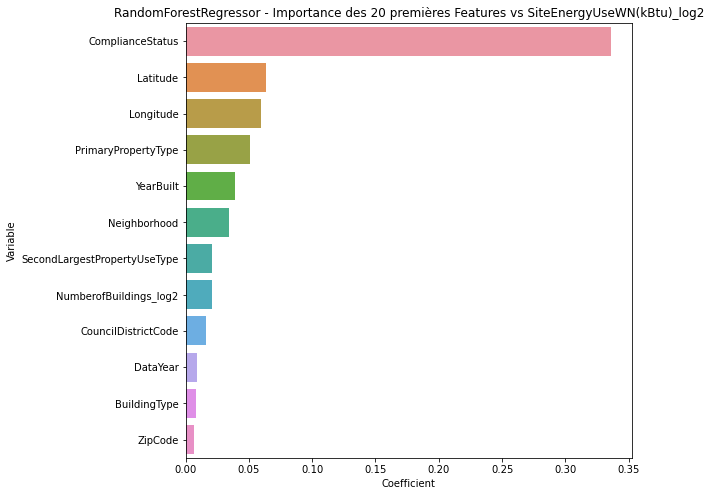

In [29]:
plotBestFeature(gridForest, 'RandomForestRegressor')

On voit que les résultats pour le RandomForest sont remarquables. La prédiction de l'emission total de gaz à effet de serre
dépend essentiellement de la colonne NumberOfFloors, LargestPropertyUseType alors que la colonne SecondLargestPropertyUseType a moins d'importance.
La prédiction de la consommation totale d'energie ne dépend que des colonnes Neighborhood et NumberOfFloors.

## Support Vector Regression

Le SVR cherche l'hyperplan (linéaire ou pas -> kernel) contenant le plus de points dans ses frontières.

## ADABoost Regressor

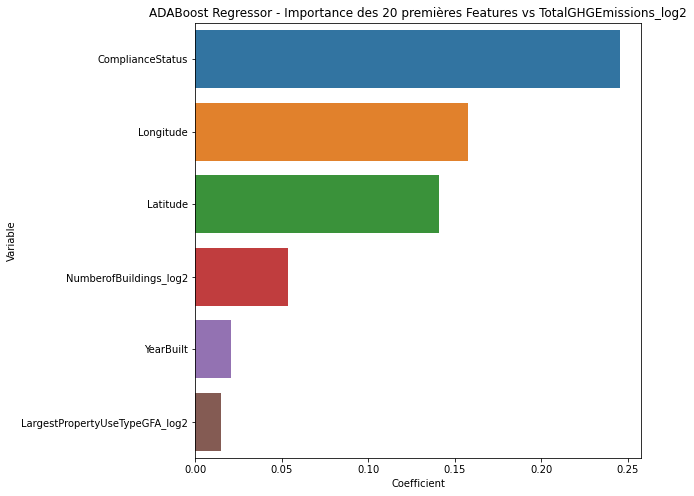

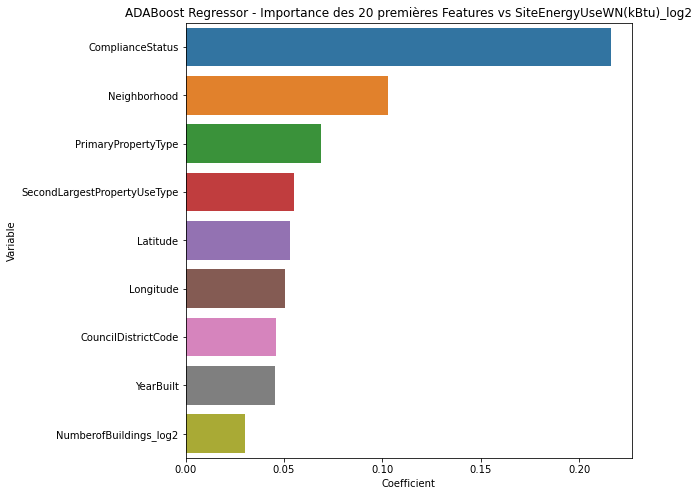

In [30]:
plotBestFeature(gridAdaBoost, 'ADABoost Regressor')

In [164]:
X = data[['NumberofFloors_log2', 'ComplianceStatus', 'SecondLargestPropertyUseType', 'PrimaryPropertyType', 
          'Neighborhood', 'NumberofBuildings_log2', 'PropertyGFATotal_log2', 'YearBuilt','YearBuilt',
         'ZipCode', 'Longitude', 'Latitude']]


target_list = ['TotalGHGEmissions_log2', 'SiteEnergyUseWN(kBtu)_log2'] 
parameters = {'tol' : [0.001], # seuil en dessous duquel sklearn ne cherche plus à optimiser
              "alpha": [0.001, 0.01],  #coefficient de pénalité
              "l1_ratio": [0.2, 0.95]}

model = ElasticNet()
resEs2, gridElasticNet2 = modelise(data, parameters, model, 'ElasticNet', X)
results = resEs2

parameters = {
    'n_estimators' : [10,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto'] # auto = ttes les features / sqrt = sqrt(nbre de features)
}
model = RandomForestRegressor()
resFt2, gridForest2 = modelise(data, parameters, model, 'Random Forest',X)
results = results.append(resFt2)

parameters = {'gamma' : [1e-3, 1e-2], #coefficient permettant de coller plus ou moins aux données
              'epsilon' : [0.01, 0.1], #erreur tolérée par l'algorithme
              'C' : [10]} #parametre de régularisation

model = SVR()
resSv2, grid2 = modelise(data, parameters, model, 'SVR',X)
results = results.append(res)

parameters = {
    'n_estimators' : [100,500]
}
model = AdaBoostRegressor()
resAb2, gridAdaBoost2 = modelise(data, parameters, model, 'ADABoost Regressor',X)
results = results.append(resAb2)
results 

TotalGHGEmissions_log2
0    8.019202 
1    8.095450 
2    11.016446
3    9.015973 
4    8.297467 
Name: TotalGHGEmissions_log2, dtype: float64
(5264,)
(1317,)
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ...............alpha=0.001, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.001, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ..............alpha=0.001, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, tol=0.001; total time=   0.0s
[CV] END ................alpha=0.01, l1_ratio=0.2, t

[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   4.0s
[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   3.4s
[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   3.2s
[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   3.2s
[CV] END .....................C=10, epsilon=0.01, gamma=0.01; total time=   3.8s
[CV] END .....................C=10, epsilon=0.01, gamma=0.01; total time=   4.3s
[CV] END .....................C=10, epsilon=0.01, gamma=0.01; total time=   3.8s
[CV] END .....................C=10, epsilon=0.01, gamma=0.01; total time=   3.7s
[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   2.8s
[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   3.3s
[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   2.7s
[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   2.8s
[CV] END ...................

,Variable target,Modèle,Score RMSE,Score RMSE / moyenne,Best param
0,TotalGHGEmissions_log2,Random Forest,0.194586,0.038035,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
1,SiteEnergyUseWN(kBtu)_log2,Random Forest,0.074335,0.003537,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}"
0,TotalGHGEmissions_log2,Random Forest,0.194586,0.038035,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
1,SiteEnergyUseWN(kBtu)_log2,Random Forest,0.074335,0.003537,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}"
0,TotalGHGEmissions_log2,Random Forest,0.194586,0.038035,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
1,SiteEnergyUseWN(kBtu)_log2,Random Forest,0.074335,0.003537,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}"
0,TotalGHGEmissions_log2,Random Forest,0.194586,0.038035,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
1,SiteEnergyUseWN(kBtu)_log2,Random Forest,0.074335,0.003537,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}"


In [168]:
results2 = resEs
results2 = results2.append(resFt)
results2 = results2.append(resSv)
results2 = results2.append(resAb)
results2 = results2.reset_index()
results2.drop(columns=['index'])

,Variable target,Modèle,Score RMSE,Score RMSE / moyenne,Best param
0,TotalGHGEmissions_log2,ElasticNet,0.984925,0.173708,"{'alpha': 0.001, 'l1_ratio': 0.2, 'tol': 0.001}"
1,SiteEnergyUseWN(kBtu)_log2,ElasticNet,1.333439,0.063474,"{'alpha': 0.01, 'l1_ratio': 0.95, 'tol': 0.001}"
2,TotalGHGEmissions_log2,Random Forest,0.675981,0.119221,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
3,SiteEnergyUseWN(kBtu)_log2,Random Forest,1.443189,0.068698,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
4,TotalGHGEmissions_log2,SVR,0.945947,0.166834,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"
5,SiteEnergyUseWN(kBtu)_log2,SVR,1.322160,0.062937,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.001}"
6,TotalGHGEmissions_log2,ADABoost Regressor,1.189875,0.209855,{'n_estimators': 500}
7,SiteEnergyUseWN(kBtu)_log2,ADABoost Regressor,2.258621,0.107514,{'n_estimators': 100}


## Performance des différents modèles

In [34]:
dictList = [gridElasticNet, gridForest, grid, gridAdaBoost]

#X = preprocess(X)

X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X, data['TotalGHGEmissions_log2'], test_size = 0.2, random_state = 15)
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X, data['SiteEnergyUseWN(kBtu)_log2'], test_size = 0.2, random_state = 15)

models_list_em = []
models_list_en = []
for dictionnaire in dictList:
    models_list_em.append(dictionnaire['TotalGHGEmissions_log2'])

for dictionnaire in dictList:
    models_list_en.append(dictionnaire['SiteEnergyUseWN(kBtu)_log2'])   
    
for model in tqdm(models_list_em):
    print(model.best_estimator_)    
    %timeit model.best_estimator_.predict(X_test_em)
    print('')
    
for model in tqdm(models_list_en):
    print(model.best_estimator_)    
    %timeit model.best_estimator_.predict(X_test_en)
    print('')

  0%|          | 0/4 [00:00<?, ?it/s]

ElasticNet(alpha=0.001, l1_ratio=0.05, tol=0.01)


 25%|██▌       | 1/4 [00:03<00:09,  3.27s/it]

3.89 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

RandomForestRegressor()


 50%|█████     | 2/4 [00:07<00:07,  3.66s/it]

48 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SVR(C=10, gamma=0.01)


 75%|███████▌  | 3/4 [00:20<00:07,  7.98s/it]

1.64 s ± 98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

AdaBoostRegressor(n_estimators=100)


  0%|          | 0/4 [00:00<?, ?it/s]

27.2 ms ± 626 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

ElasticNet(alpha=0.1, l1_ratio=0.1)


 25%|██▌       | 1/4 [00:02<00:08,  2.79s/it]

3.42 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

RandomForestRegressor()


 50%|█████     | 2/4 [00:06<00:07,  3.51s/it]

48.9 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SVR(C=10, gamma=0.001)


 75%|███████▌  | 3/4 [00:20<00:07,  7.94s/it]

1.6 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

AdaBoostRegressor(n_estimators=100)


100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

30.8 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



In [198]:
X.shape

(6581, 116)

Le plus rapide est le modèle ElsaticNet Regression (10.8 et 9.77 ms). le modèle SVR est le moins rapide à entrainer.

## Intérêt du Energy Star Score

In [35]:
X_en = data[~data['ENERGYSTARScore'].isna()]['ENERGYSTARScore']
y_en = data[~data['ENERGYSTARScore'].isna()]['SiteEnergyUseWN(kBtu)_log2']

In [36]:
X_en_train, X_en_test, y_en_train, y_en_test = \
                        train_test_split(X_en, 
                                         y_en,  
                                         test_size = 0.2, 
                                         random_state = 42
                                        )
X_en_train = X_en_train.values.reshape(-1,1)
X_en_test = X_en_test.values.reshape(-1,1)

In [37]:
X_en_train.shape

(3999, 1)

In [38]:
parameters = {'alpha': [0.01], 'l1_ratio': [0.95], 'tol': [0.001]}

model = ElasticNet()
grid = GridSearchCV(model,
                               param_grid = parameters,
                               verbose=2,
                               cv=5)
grid.fit(X_en_train, y_en_train)
print(math.sqrt(mean_squared_error(grid.predict(X_en_test), y_en_test)))
print(grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...............alpha=0.01, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.95, tol=0.001; total time=   0.0s
[CV] END ...............alpha=0.01, l1_ratio=0.95, tol=0.001; total time=   0.0s
1.8946077349985
{'alpha': 0.01, 'l1_ratio': 0.95, 'tol': 0.001}


In [39]:
print(math.sqrt(mean_squared_error(grid.predict(X_en_test), y_en_test))/ y_en_test.mean())

0.089979736898729


## Conclusion 

L'EnergyStarScore est très pertinent pour prédire et donc anticiper les besoins en electricité des batiments. Mais étant compliqué à calculer, il est possible de le prédire via les colonnes NumberOfFloors, NeighborHood, NumberOfBuildings, PropertyGFATotal, SecondLargestUseType, LargestPropertyUseType, BuildingType qui sont tous des informations nécessitant peu de mesures.